<a href="https://colab.research.google.com/github/Shenzzzz1980/dataset/blob/main/MMN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import uploaded dataset from github into Colab.

In [1]:
!pip install mne
!pip install h5py
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


!wget --no-check-certificate \
    "https://github.com/Shenzzzz1980/dataset/archive/refs/heads/main.zip" \
    -O "/tmp/datasets.zip"


zip_ref = zipfile.ZipFile('/tmp/datasets.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 33.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-06-22 16:19:13--  https://github.com/Shenzzzz1980/dataset/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Shenzzzz1980/dataset/zip/refs/heads/main [following]
--2023-06-22 16:19:14--  https://codeload.github.com/Shenzzzz1980/dataset/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/datasets.zip’



2. Create training data and testing data.

In [2]:
import mne
import csv
import pandas as pd
import glob

path1 = "/tmp/dataset-main/mmn_train_x/deviant"
deviant = glob.glob(path1 + '**/*.csv',recursive=True)

path2 = "/tmp/dataset-main/mmn_train_x/standard"
standard = glob.glob(path2 + '**/*.csv',recursive=True)

#read the csv file of both standard and deviant training datasets
list_deviant = [pd.read_csv (d1, index_col=None, header=0) for d1 in deviant]
df_deviant = pd.concat(list_deviant, axis=0, ignore_index=True)

list_standard = [pd.read_csv (s1, index_col=None, header=0) for s1 in standard]
df_standard = pd.concat(list_standard, axis=0, ignore_index=True)

#combine the deviant and standard datasets for training
train = [df_deviant, df_standard]
trainf = pd.concat(train)

path3 = "/tmp/dataset-main/mmn_test_x/deviant"
deviant_test = glob.glob(path3 + '**/*.csv',recursive=True)

path4 = "/tmp/dataset-main/mmn_test_x/standard"
standard_test = glob.glob(path4 + '**/*.csv',recursive=True)

#read the csv file of both standard and deviant testing datasets
list_deviant_test = [pd.read_csv (d2, index_col=None, header=0) for d2 in deviant_test]
df_deviant_test = pd.concat(list_deviant_test, axis=0, ignore_index=True)

list_standard_test = [pd.read_csv (s2, index_col=None, header=0) for s2 in standard_test]
df_standard_test = pd.concat(list_standard_test, axis=0, ignore_index=True)

#combine the deviant and standard datasets for testing
test = [df_deviant_test, df_standard_test]
testf = pd.concat(test)

trainf.shape
testf.shape

(2050, 30)

3. Create the labels for both training and testing data.

In [3]:
import tensorflow as tf
import cv2

d = os.listdir("/tmp/dataset-main/mmn_train_x/deviant")
s = os.listdir("/tmp/dataset-main/mmn_train_x/standard")
filenames = d + s
labels1 = []
for filename in filenames:
  label1 = filename.split('.')[0]
  if label1 == "Deviants":
    labels1.append(1)
  else:
    labels1.append(0)

ytrain = pd.DataFrame({'filename': filenames,
                   'label1': labels1})
ytrain.to_csv('y_train.csv')
y_train = pd.read_csv('y_train.csv')['label1'].values

dtest = os.listdir("/tmp/dataset-main/mmn_test_x/deviant")
stest = os.listdir("/tmp/dataset-main/mmn_test_x/standard")
ytest = dtest + stest
labels2 = []
for filename in ytest:
  label2 = filename.split('.')[0]
  if label2 == "Deviants":
    labels2.append(1)
  else:
    labels2.append(0)

ytest = pd.DataFrame({'filename': ytest,
                   'label2': labels2})
ytest.to_csv('y_test.csv')
y_val = pd.read_csv('y_test.csv')['label2'].values


4. Reshaping the training and testing data to sastified the input dimension of the deep learning model.

In [4]:
from tensorflow.keras import utils as np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

x_train = trainf
x_test = testf


x_train = x_train.values
x_test = x_test.values

x_train   = x_train.reshape(54, 30, 205, 1)
x_val     = x_test.reshape(10, 30, 205, 1)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)



(54, 30, 205, 1)
(10, 30, 205, 1)
(54,)
(10,)


5. Building CNN model based on EEGNet.

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from math import floor




def EEGNett(nb_classes = 2, Chans = 30, Samples = 205,
            dropoutRate = 0.25, kernLength = 32, F1 = 8,
            D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):

    input1   = Input(shape = (Chans, Samples, 1))

    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                      input_shape = (Chans, Samples, 1),
                                      use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                  depth_multiplier = D,
                                  depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 5))(block1)
    block1       = Dropout(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                              use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 5))(block2)
    block2       = Dropout(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                    kernel_constraint = max_norm(norm_rate))(flatten)
    softmax     = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)


6. Hyperparameter tuning via bayesian optimization method.

In [6]:
!pip install bayesian-optimization==1.4.1
from functools import partial
from bayes_opt import BayesianOptimization

def fit_with(dropoutRate, lr, temporalfilter_F1, spatialfilter_D):

    # Create the model using a specified hyperparameters.
    model = EEGNett(nb_classes = 2, Chans = 30, Samples = 205,
                    dropoutRate = dropoutRate, kernLength = 32, F1 = int(round(temporalfilter_F1)),
                    D = int(round(spatialfilter_D)), F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')

    # Train the model for a specified number of epochs.
    optimizer= Adam(learning_rate = lr)
    model.compile(optimizer=optimizer,
                  loss    = 'sparse_categorical_crossentropy',
                  metrics ='accuracy')
    callback = tf.keras.callbacks.EarlyStopping (monitor='val_loss', mode='min', verbose = 0, patience=3)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    # Train the model with the train dataset.
    model.fit(x_train, y_train, validation_data = (x_val,y_val),callbacks = [callback, mc], epochs = 100, verbose = 0)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(x_val,y_val, verbose=1)

    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')

    # Return the accuracy.

    return score[1]

fit_with_partial = partial(fit_with)

bounds = {'dropoutRate': (0.1, 0.5),
          'temporalfilter_F1': (4, 10),
          'lr' : (1e-6, 0.01),
          'spatialfilter_D' : (1, 4)}



hytune = BayesianOptimization(
    f            = fit_with_partial,
    pbounds      = bounds,
    random_state = 1
)


hytune.maximize(init_points = 30, n_iter = 0,)


for i, res in enumerate(hytune.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(hytune.max)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reason for being yanked: https://github.com/fmfn/BayesianOptimization/pull/388
|   iter    |  target   | dropou... |    lr     | spatia... | tempor... |
-------------------------------------------------------------------------
1/1 [==============================] - 0s 35ms/step - loss: 0.3461 - accuracy: 0.8000
Test loss: 0.3460674285888672
Test accuracy: 0.800000011920929


| 1         | 0.8       | 0.2668    | 0.007204  | 1.0       | 5.814     |
1/1 [==============================] - 0s 40ms/step - loss: 0.1420 - accuracy: 1.0000
Test loss: 0.1419922113418579
Test accuracy: 1.0


| 2         | 1.0       | 0.1587    | 0.0009243 | 1.559     | 6.073     |
1/1 [==============================] - 0s 36ms/step - loss: 0.2326 - accuracy: 0.9000
Test loss: 0.23260453343391418
Test accuracy: 0.8999999761581421


| 3         | 0.9       | 0.2587    | 0.005389  | 2.258     | 8.111     |
1/1 [======

7. Setting the tuned hyperparameters for the model before compiling and training it.

In [7]:
newparam = hytune.max['params']
lr = newparam['lr']
dropoutRate = newparam['dropoutRate']
F1 = newparam['temporalfilter_F1']
D = newparam['spatialfilter_D']

newparam

model_tuned = EEGNett(nb_classes = 2, Chans = 30, Samples = 205,
                       dropoutRate = newparam['dropoutRate'], kernLength = 32, F1 = int(round(newparam['temporalfilter_F1'])),
                      D = int(round(newparam['spatialfilter_D'])), F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout')

model_tuned.compile(optimizer = Adam (learning_rate = newparam['lr']),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = 'accuracy')

model_tuned.summary()

callback = tf.keras.callbacks.EarlyStopping (monitor='val_loss', mode='min', verbose = 1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

fitted    = model_tuned.fit(x_train, y_train, validation_data = (x_val,y_val),callbacks = [callback, mc], epochs = 100, shuffle = True, verbose = 1)
saved_model = load_model('best_model.h5')

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 30, 205, 1)]      0         
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 205, 6)        192       
                                                                 
 batch_normalization_90 (Bat  (None, 30, 205, 6)       24        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_30 (Depthw  (None, 1, 205, 12)       360       
 iseConv2D)                                                      
                                                                 
 batch_normalization_91 (Bat  (None, 1, 205, 12)       48        
 chNormalization)                                                
                                                          

8. Evaluate the model training process.

1/1 [==============================] - 0s 203ms/step - loss: 0.3255 - accuracy: 1.0000
Validation score:  0.3254789710044861
Validation accuracy:  1.0


Text(0, 0.5, 'Accuracy')

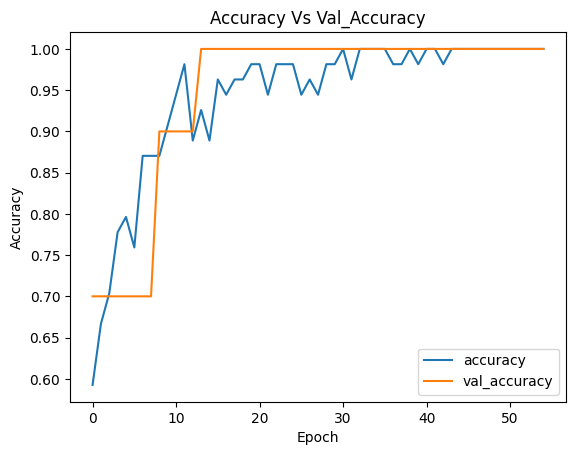

In [8]:
score = saved_model.evaluate(x_val, y_val)
print("Validation score: ", score[0])
print("Validation accuracy: ", score[1])

plt.plot(fitted.history['accuracy'])
plt.plot(fitted.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


Text(0, 0.5, 'loss')

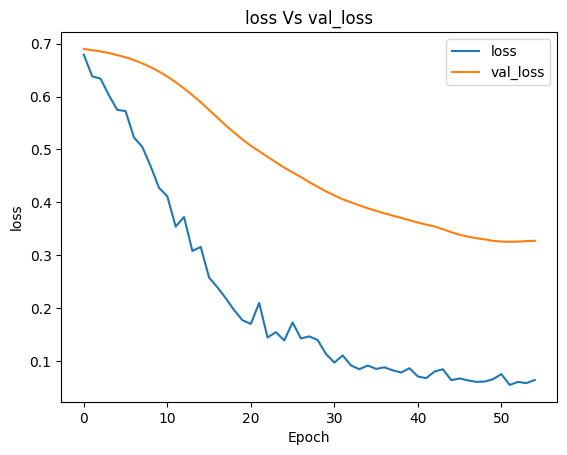

In [9]:
plt.plot(fitted.history['loss'])
plt.plot(fitted.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.title('loss Vs val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')

9. Plotting Confusion matrix.

Confusion matrix, without normalization


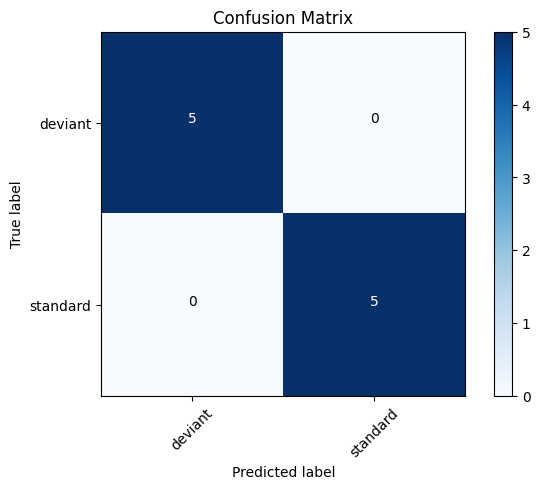

In [10]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

predictions = saved_model.predict(x_val, batch_size=10, verbose=0)
rounded_predictions = np.argmax(predictions, axis=-1)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true=y_val, y_pred=rounded_predictions)
cm_plot_labels = ['deviant','standard']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

10. Evaluate the model performance.

In [11]:
import numpy
import sklearn.metrics

print("Model Validation MMN")
print("********************")
acc = (cm[0][0] + cm[-1][-1]) / numpy.sum(cm)
print("Accuracy:", acc)

precision = sklearn.metrics.precision_score(y_true=y_val, y_pred=rounded_predictions)
print("Precision: ", precision)

recall = sklearn.metrics.recall_score(y_true=y_val, y_pred=rounded_predictions)
print("Recall: ", recall)

f1 = 2*((precision * recall)/(precision + recall))
print("F1 = ", f1)

kappa = sklearn.metrics.cohen_kappa_score(y1=y_val, y2=rounded_predictions)
print ("Kappa Coefficient: ", kappa)

Model Validation MMN
********************
Accuracy: 1.0
Precision:  1.0
Recall:  1.0
F1 =  1.0
Kappa Coefficient:  1.0


1/1 [==============================] - 0s 117ms/step
AUC score:  1.0


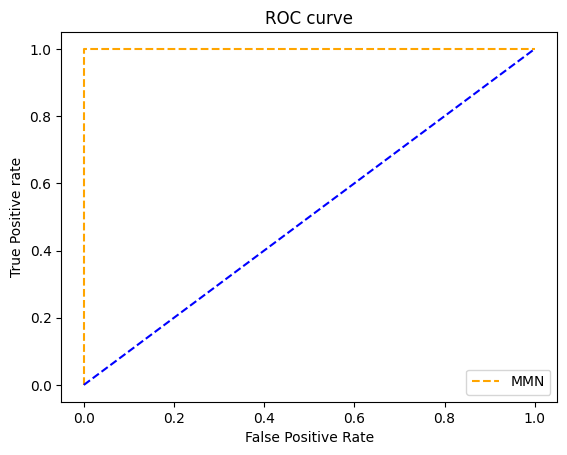

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


pred_prob1 = saved_model.predict(x_val)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_val, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(y_val, pred_prob1[:,1])

print('AUC score: ', auc_score1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='MMN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

11. Final validation and evaluation of the model.

In [13]:
path5 = "/tmp/dataset-main/mmn_valid_x/deviant"
deviant_valid = glob.glob(path5 + '**/*.csv',recursive=True)

path6 = "/tmp/dataset-main/mmn_valid_x/standard"
standard_valid = glob.glob(path6 + '**/*.csv',recursive=True)

list_deviant_valid = [pd.read_csv (d3, index_col=None, header=0) for d3 in deviant_valid]
df_deviant_valid = pd.concat(list_deviant_valid, axis=0, ignore_index=True)

list_standard_valid = [pd.read_csv (s3, index_col=None, header=0) for s3 in standard_valid]
df_standard_valid = pd.concat(list_standard_valid, axis=0, ignore_index=True)

valid = [df_deviant_valid, df_standard_valid]
validf = pd.concat(valid)

validf.shape

(820, 30)

In [14]:
dvalid = os.listdir("/tmp/dataset-main/mmn_valid_x/deviant")
svalid = os.listdir("/tmp/dataset-main/mmn_valid_x/standard")
yvalid = dvalid + svalid
labels3 = []
for filename in yvalid:
  label3 = filename.split('.')[0]
  if label3 == "Deviants":
    labels3.append(1)
  else:
    labels3.append(0)

yvalid = pd.DataFrame({'filename': yvalid,
                   'label3': labels3})
yvalid.to_csv('y_valid.csv')
y_valid = pd.read_csv('y_valid.csv')['label3'].values

x_valid = validf
x_valid = x_valid.values

x_valid   = x_valid.reshape(4, 30, 205, 1)


print(x_valid.shape)
print(y_valid.shape)


(4, 30, 205, 1)
(4,)


Confusion matrix, without normalization


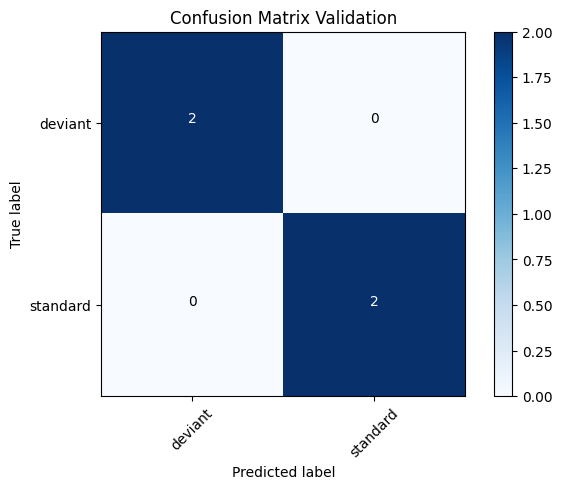

In [15]:
predictions_valid = saved_model(x_valid, training=False)
rounded_predictions_valid = np.argmax(predictions_valid, axis=-1)

cm_valid= confusion_matrix(y_true=y_valid, y_pred=rounded_predictions_valid)
cm_valid_plot_labels = ['deviant','standard']
plot_confusion_matrix(cm=cm_valid, classes=cm_plot_labels, title='Confusion Matrix Validation')

In [16]:
print("Final Validation MMN")
print("********************")
acc_valid = (cm_valid[0][0] + cm_valid[-1][-1]) / numpy.sum(cm_valid)
print("Accuracy:", acc_valid)

precision_valid = sklearn.metrics.precision_score(y_true=y_valid, y_pred=rounded_predictions_valid)
print("Precision: ", precision_valid)

recall_valid = sklearn.metrics.recall_score(y_true=y_valid, y_pred=rounded_predictions_valid)
print("Recall: ", recall_valid)

f1_valid = 2*((precision_valid * recall_valid)/(precision_valid + recall_valid))
print("F1 = ", f1_valid)

kappa_valid = sklearn.metrics.cohen_kappa_score(y1=y_valid, y2=rounded_predictions_valid)
print ("Kappa Coefficient: ", kappa_valid)

Final Validation MMN
********************
Accuracy: 1.0
Precision:  1.0
Recall:  1.0
F1 =  1.0
Kappa Coefficient:  1.0


1/1 [==============================] - 0s 27ms/step
AUC score:  1.0


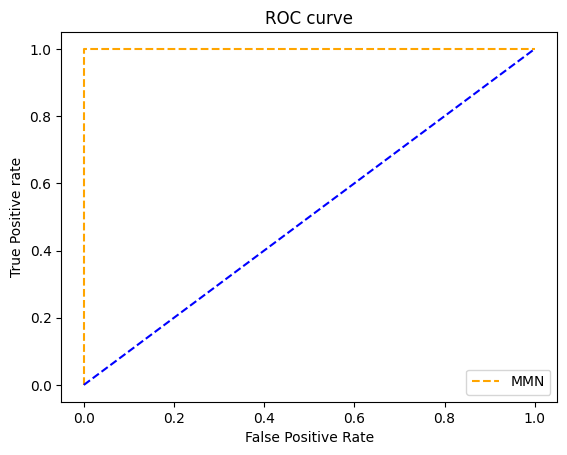

In [17]:

pred_prob2 = saved_model.predict(x_valid)

# roc curve for models
fpr2, tpr2, thresh2 = roc_curve(y_valid, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_valid))]
p_fpr, p_tpr, _ = roc_curve(y_valid, random_probs, pos_label=1)

# auc scores
auc_score2 = roc_auc_score(y_valid, pred_prob2[:,1])

print('AUC score: ', auc_score2)

# plot roc curves
plt.plot(fpr2, tpr2, linestyle='--',color='orange', label='MMN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();